# AI4D Research Lab Tanzania Tourism Prediction
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  LabelEncoder, OneHotEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import pycountry_convert as pc
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

# Read the training and testing data


In [2]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
ID = test_df['Tour_ID']

# The Features:

In [3]:
Features_Definitions = pd.read_csv("VariableDefinitions.csv")
Features_Definitions

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


## Fix Some Typos in the Data

In [4]:
for dataset in (train_df,test_df):
    for i in range(0,dataset.shape[0]):
        if(dataset['main_activity'][i] == 'Widlife Tourism'):
            dataset['main_activity'][i] = 'Wildlife Tourism'
        if(dataset['country'][i] == 'SWIZERLAND'):
            dataset['country'][i] = 'SWITZERLAND'
        if(dataset['country'][i] == 'MORROCO'):
            dataset['country'][i] = 'MOROCCO'
        if(dataset['country'][i] == 'MALT'):
            dataset['country'][i] = 'MALTA'
        if(dataset['country'][i] == 'COSTARICA'):
            dataset['country'][i] = 'COSTA RICA'

# Exploratory Data Analysis:

In [5]:
train_df.shape

(18506, 21)

In [6]:
test_df.shape

(6169, 20)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                6169 non-null   object 
 1   country                6169 non-null   object 
 2   age_group              6169 non-null   object 
 3   travel_with            5808 non-null   object 
 4   total_female           6167 non-null   float64
 5   total_male             6168 non-null   float64
 6   purpose                6169 non-null   object 
 7   main_activity          6169 non-null   object 
 8   info_source            6169 non-null   object 
 9   tour_arrangement       6169 non-null   object 
 10  package_transport_int  6169 non-null   object 
 11  package_accomodation   6169 non-null   object 
 12  package_food           6169 non-null   object 
 13  package_transport_tz   6169 non-null   object 
 14  package_sightseeing    6169 non-null   object 
 15  pack

In [9]:
train_df.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.000,2.000,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.000,1.000,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.000,1.000,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.000,1.000,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.000,1.000,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [10]:
test_df.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.000,1.000,Leisure and Holidays,Wildlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.000,1.000,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.000,1.000,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.000,1.000,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.000,1.000,Business,Wildlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [11]:
train_df.describe()

,total_female,total_male,night_mainland,night_zanzibar
count,18504.000,18500.000,18506.000,18506.000
mean,0.936,0.999,9.142,2.494
std,1.216,1.173,14.127,5.275
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,3.000,0.000
50%,1.000,1.000,6.000,0.000
75%,1.000,1.000,11.000,4.000
max,49.000,58.000,365.000,240.000


In [12]:
test_df.describe()

,total_female,total_male,night_mainland,night_zanzibar
count,6167.000,6168.000,6169.000,6169.000
mean,0.922,1.018,9.312,2.586
std,1.173,1.526,16.367,5.465
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,3.000,0.000
50%,1.000,1.000,6.000,0.000
75%,1.000,1.000,11.000,4.000
max,30.000,90.000,664.000,174.000


In [13]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

Tour_ID 18506
country 131
age_group 5
travel_with 5
total_female 24
total_male 24
purpose 8
main_activity 9
info_source 8
tour_arrangement 2
package_transport_int 2
package_accomodation 2
package_food 2
package_transport_tz 2
package_sightseeing 2
package_guided_tour 2
package_insurance 2
night_mainland 110
night_zanzibar 60
first_trip_tz 2
cost_category 6


In [14]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

Tour_ID 6169
country 118
age_group 5
travel_with 5
total_female 19
total_male 18
purpose 8
main_activity 9
info_source 8
tour_arrangement 2
package_transport_int 2
package_accomodation 2
package_food 2
package_transport_tz 2
package_sightseeing 2
package_guided_tour 2
package_insurance 2
night_mainland 91
night_zanzibar 44
first_trip_tz 2


# Plots

<AxesSubplot:>

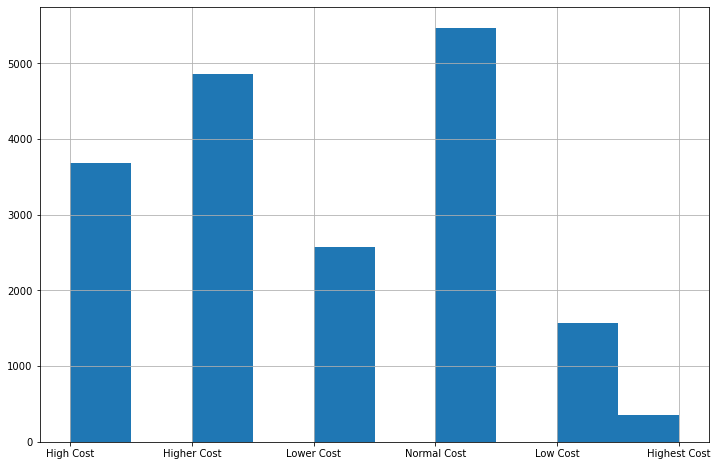

In [15]:
#Target Histogram
train_df['cost_category'].hist()

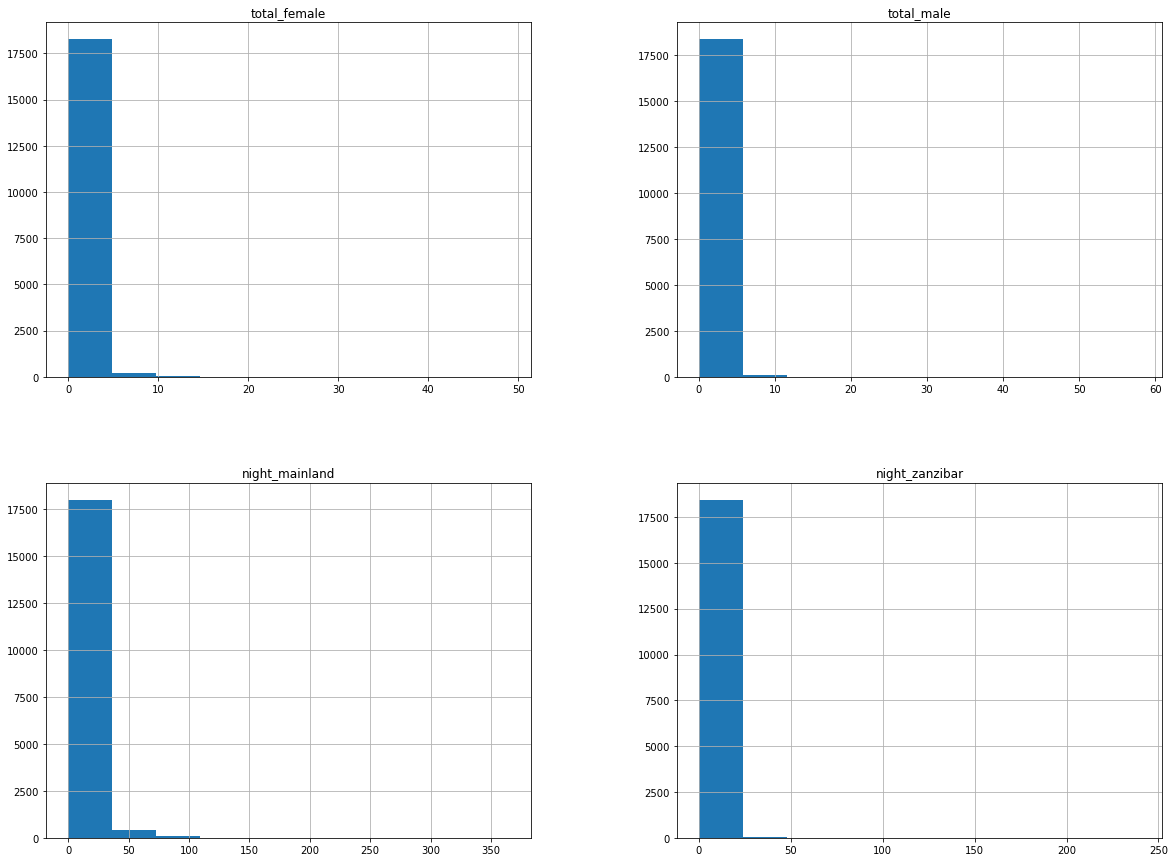

In [16]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

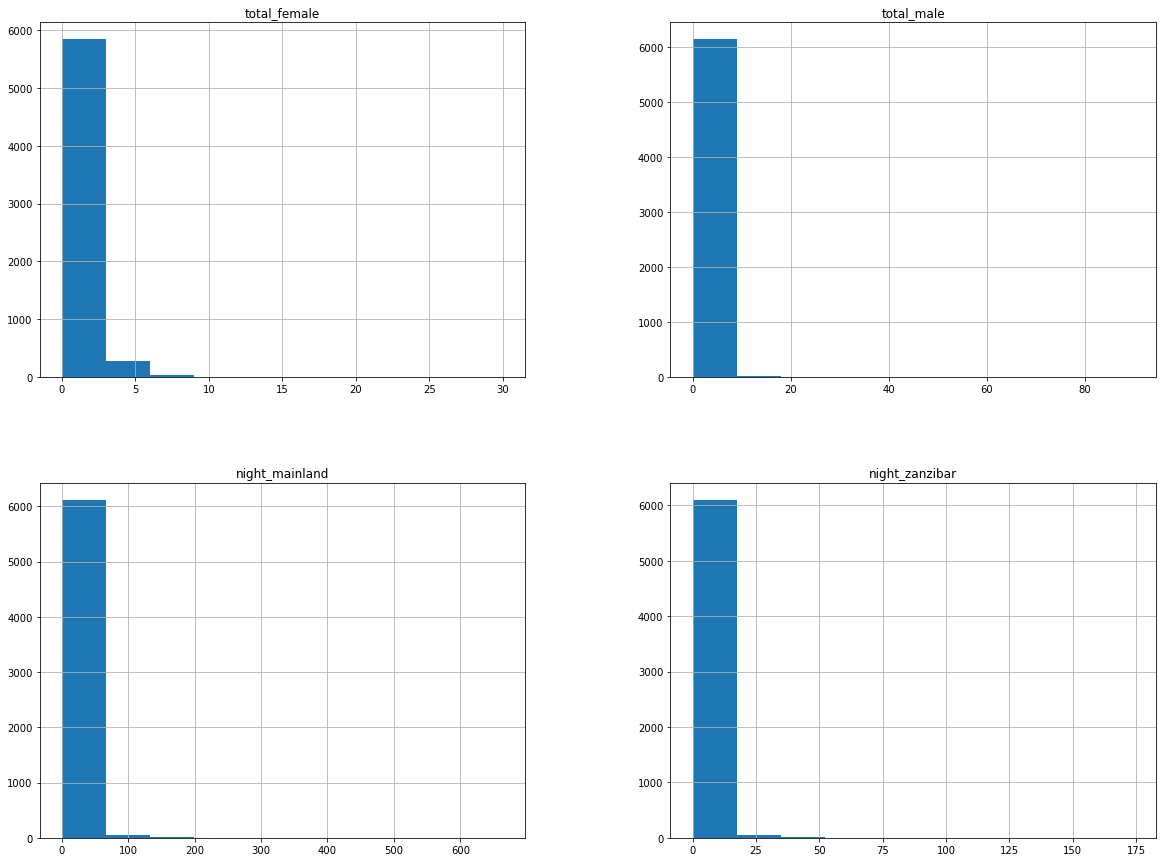

In [17]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

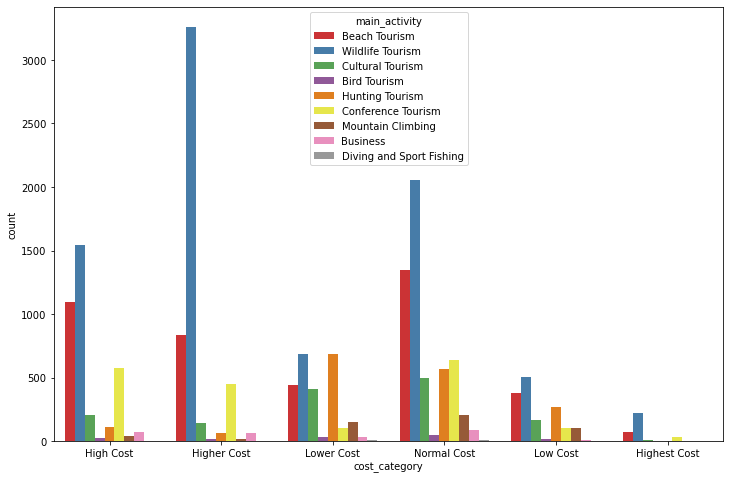

In [18]:
#main_activity ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="main_activity", palette="Set1");

##### Most of tourists tend to like Wildlife Tourism. 
##### We can see as well the Conference Tourism is famous amongst those who spend high costs while Hunting Tourism is for those who spend low costs.

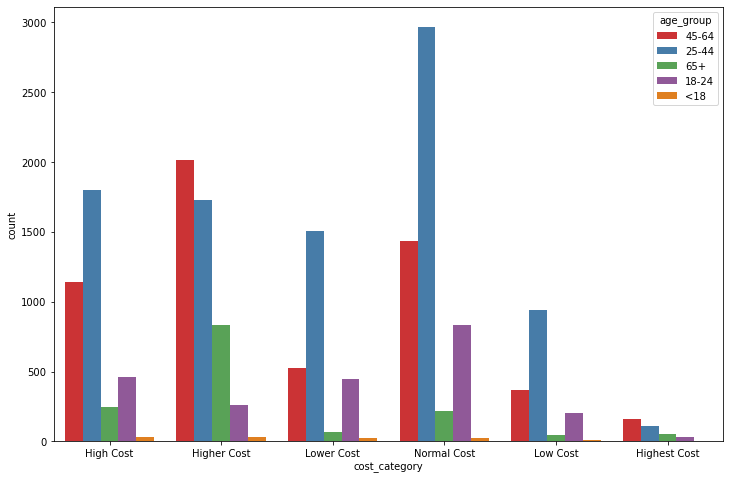

In [19]:
#Age_group ----- cost_category
sns.countplot( x='cost_category', data=train_df, hue="age_group", palette="Set1");

##### Those who are aged less than 45 years tend to spend much less money than those who are above 45.

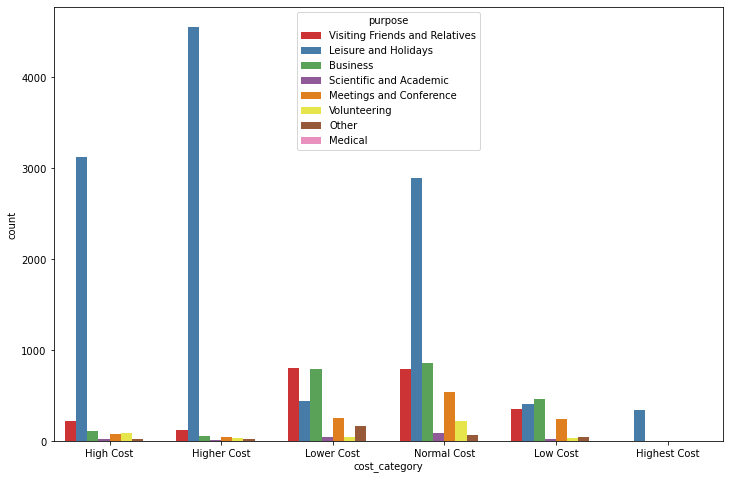

In [20]:
#Purpose ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="purpose", palette="Set1");

##### Appearently, most of the tourists come to Tanzania to enjoy the holiday.

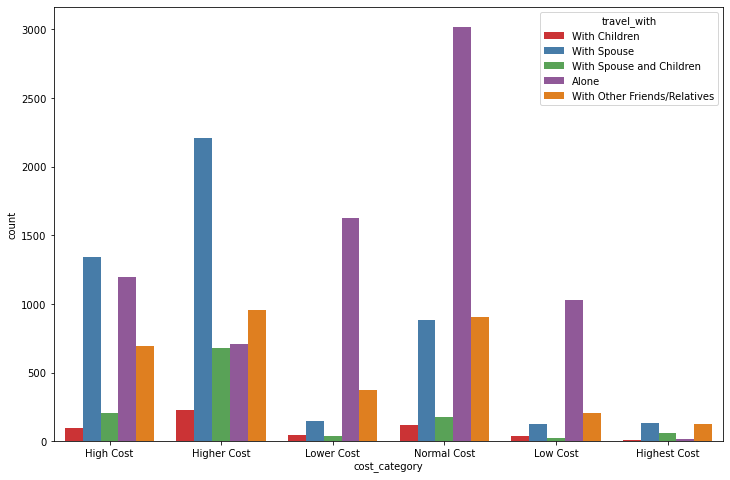

In [21]:
#travel_with ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="travel_with", palette="Set1");

##### Although most of touriests come alone, a significant amount of them come with their spouses.

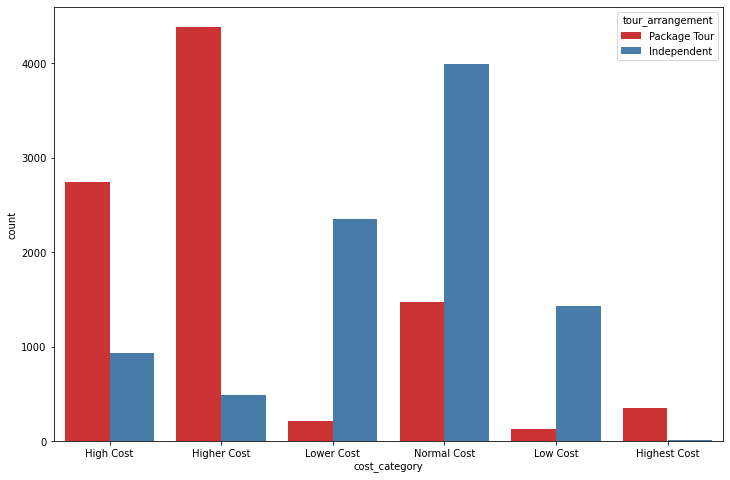

In [22]:
#tour_arrangement ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="tour_arrangement", palette="Set1");

##### The higher is the tourists spendings, the more likely they arranged the tour using a Package tour.

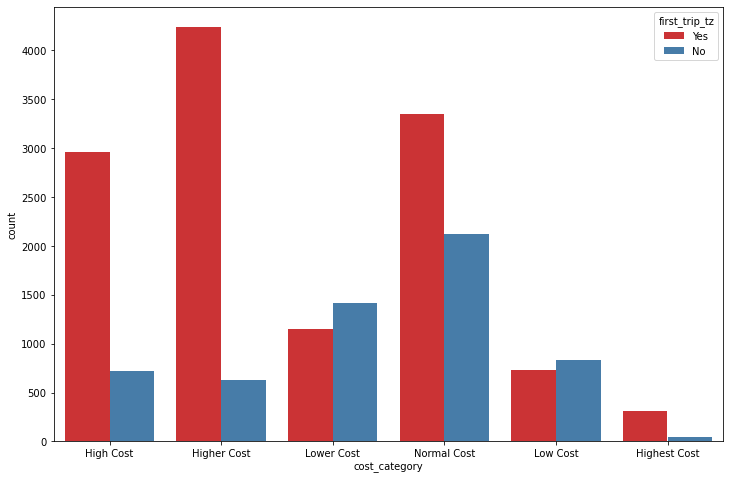

In [23]:
#first_trip_tz ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="first_trip_tz", palette="Set1");

##### People who visit Tanzania for the first time are much more likely to spend more money than those who visited it before.

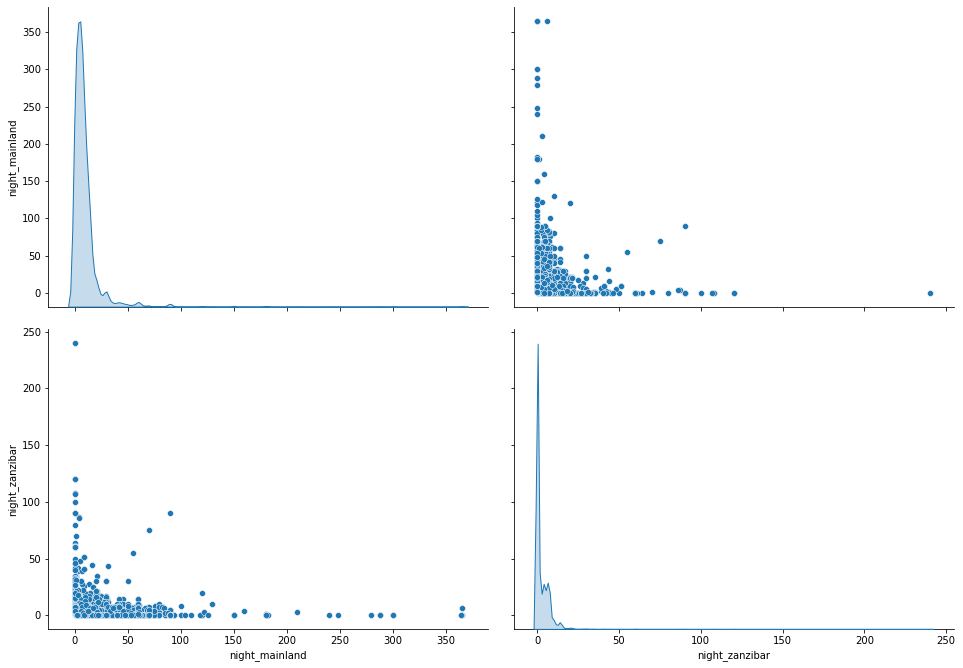

In [24]:
#night_mainland ------- night_zanzibar
attributes = ["night_mainland", "night_zanzibar"]
sns.pairplot(train_df[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

##### There are quite a lot of cases where the tourists visit Mainland but not Zanzibar and vice versa.

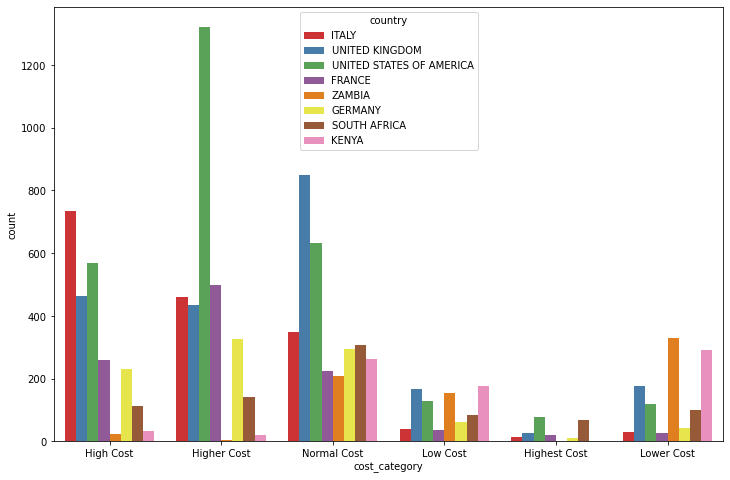

In [25]:
#country ----- cost_category 
countries = train_df[(train_df['country'] =='UNITED STATES OF AMERICA') | (train_df['country'] =='UNITED KINGDOM') | 
                     (train_df['country'] =='ITALY') | (train_df['country'] =='FRANCE') | 
                     (train_df['country'] =='GERMANY') | (train_df['country'] =='SOUTH AFRICA') | 
                     (train_df['country'] =='KENYA') | (train_df['country'] =='ZAMBIA')]

sns.countplot( x='cost_category', data=countries, hue="country", palette="Set1");

##### USA tourists are obviously the ones who spend the most.

# Feature Engineering

## Drop "ID" column

In [26]:
for dataset in (train_df,test_df):
    dataset.drop('Tour_ID',axis=1,inplace=True)

## Total Number of Tourists

In [27]:
for dataset in (train_df,test_df):
    dataset['TotalTourists'] = dataset['total_male'] + dataset['total_female']

## Tour with All the Packages

In [28]:
#Transform them to boolean
features = ['package_transport_int','package_accomodation','package_food',
            'package_transport_tz','package_sightseeing','package_guided_tour','package_insurance']
for dataset in (train_df,test_df):
    for feature in features:
        dataset[feature] = dataset[feature] == 'Yes'

#Add them together
for dataset in (train_df,test_df):
    dataset['IsFullTour'] = dataset['package_transport_int'] & dataset['package_accomodation'] & \
                           dataset['package_food'] & dataset['package_transport_tz'] & \
                           dataset['package_sightseeing'] & dataset['package_guided_tour'] & \
                           dataset['package_insurance']

## Adding Continents

In [29]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

for dataset in (train_df,test_df):
    Continents = []
    for country in dataset.country.values:
        if country == 'UNITED STATES OF AMERICA':
            Continents.append(country_to_continent('United States of America'))
        elif country == 'UAE':
            Continents.append(country_to_continent('United Arab Emirates'))
        elif country == 'KOREA':
            Continents.append(country_to_continent('South Korea'))
        elif country == 'DRC':
            Continents.append(country_to_continent('Democratic Republic of the Congo'))
        elif country == 'COMORO':
            Continents.append(country_to_continent('Comoros'))
        elif country == 'SAUD ARABIA':
            Continents.append(country_to_continent('Saudi Arabia'))
        elif country == 'PHILIPINES':
            Continents.append(country_to_continent('Philippines'))
        elif country == 'SCOTLAND':
            Continents.append('Europe')
        elif country == 'UKRAIN':
            Continents.append('Europe')
        elif country == 'SOMALI':
            Continents.append('Africa')
        elif country == 'ECUADO':
            Continents.append(country_to_continent('Ecuador'))
        elif country == 'MONECASQUE':
            Continents.append(country_to_continent('Monaco'))
        elif country == 'TRINIDAD TOBACCO':
            Continents.append(country_to_continent('Trinidad and Tobago'))
        elif country == 'BURGARIA':
            Continents.append(country_to_continent('Bulgaria'))
        elif country == 'BOSNIA':
            Continents.append(country_to_continent('Bosnia and Herzegovina'))
        elif country == 'DJIBOUT':
            Continents.append(country_to_continent('Djibouti'))
        else:
            Continents.append(country_to_continent((country).title()))
    dataset['Continent'] = Continents


## Aggregations Features

In [30]:
for dataset in (train_df,test_df):
    dataset['NightsSTR'] = dataset['night_mainland'].astype(str) + dataset['night_zanzibar'].astype(str)
    dataset['TouristsSTR'] = dataset['total_male'].astype(str) + dataset['total_female'].astype(str)

In [31]:
train_df1 = train_df.copy()
test_df1 = test_df.copy()
for f in ['total_male','total_female']:
    df1 = pd.concat([train_df1,test_df1])
    median = df1[f].median()
    for dataset in (train_df1,test_df1):
        dataset[f] = dataset[f].fillna(median) 

CountryCosts = dict(train_df1.groupby('country')['cost_category'].agg(lambda x: x.value_counts().index[0]))
ContinentsCosts = dict(train_df1.groupby('Continent')['cost_category'].agg(lambda x: x.value_counts().index[0]))
AgesCosts = dict(train_df1.groupby('age_group')['cost_category'].agg(lambda x: x.value_counts().index[0]))
PurposeCosts = dict(train_df1.groupby('purpose')['cost_category'].agg(lambda x: x.value_counts().index[0]))
ActivityCosts = dict(train_df1.groupby('main_activity')['cost_category'].agg(lambda x: x.value_counts().index[0]))
InfoCosts = dict(train_df1.groupby('info_source')['cost_category'].agg(lambda x: x.value_counts().index[0]))
TouristsCosts = dict(train_df1.groupby('TotalTourists')['cost_category'].agg(lambda x: x.value_counts().index[0]))


for dataset in (train_df,test_df):
    dataset['CountryCosts'] = dataset['country'].map(CountryCosts)
    dataset['ContinentsCosts'] = dataset['Continent'].map(ContinentsCosts)
    dataset['AgesCosts'] = dataset['age_group'].map(AgesCosts)
    dataset['PurposeCosts'] = dataset['purpose'].map(PurposeCosts)
    dataset['ActivityCosts'] = dataset['main_activity'].map(ActivityCosts)
    dataset['InfoCosts'] = dataset['info_source'].map(InfoCosts)

In [32]:
TouristsCountry = dict(df1.groupby('country')['TotalTourists'].median())
AgesCountry = dict(df1.groupby('country')['age_group'].agg(lambda x: x.value_counts().index[0]))
PurposeCountry = dict(df1.groupby('country')['purpose'].agg(lambda x: x.value_counts().index[0]))
ActivityCountry = dict(df1.groupby('country')['main_activity'].agg(lambda x: x.value_counts().index[0]))
InfoCountry = dict(df1.groupby('country')['info_source'].agg(lambda x: x.value_counts().index[0]))



TouristsContinent = dict(df1.groupby('Continent')['TotalTourists'].median())
AgesContinent = dict(df1.groupby('Continent')['age_group'].agg(lambda x: x.value_counts().index[0]))
PurposeContinent = dict(df1.groupby('Continent')['purpose'].agg(lambda x: x.value_counts().index[0]))
ActivityContinent = dict(df1.groupby('Continent')['main_activity'].agg(lambda x: x.value_counts().index[0]))
InfoContinent = dict(df1.groupby('Continent')['info_source'].agg(lambda x: x.value_counts().index[0]))


for dataset in (train_df,test_df):
    dataset['TouristsCountry'] = dataset['country'].map(TouristsCountry)
    dataset['AgesCountry'] = dataset['country'].map(AgesCountry)
    dataset['PurposeCountry'] = dataset['country'].map(PurposeCountry)
    dataset['ActivityCountry'] = dataset['country'].map(ActivityCountry)
    dataset['InfoCountry'] = dataset['country'].map(InfoCountry)

    
    dataset['TouristsContinent'] = dataset['Continent'].map(TouristsContinent)
    dataset['AgesContinent'] = dataset['Continent'].map(AgesContinent)
    dataset['PurposeContinent'] = dataset['Continent'].map(PurposeContinent)
    dataset['ActivityContinent'] = dataset['Continent'].map(ActivityContinent)
    dataset['InfoContinent'] = dataset['Continent'].map(InfoContinent)

## Interaction Features (1)

In [33]:
for dataset in (train_df,test_df):
    dataset['Country_Tour'] = dataset['country'] + dataset['tour_arrangement']
    dataset['Tourists_Ages'] = dataset['TotalTourists'].astype(str) + dataset['age_group']
    dataset["TotalNights"] = dataset["night_mainland"] + dataset["night_zanzibar"]
    dataset['Night_Tourists'] = dataset['TotalNights'] * dataset['TotalTourists']
    dataset['Males_Females'] = dataset['total_male'] * dataset['total_female']

## Longitude and Latitude of Countries

In [34]:
latitude = { 'BOLIVIA':-17.0568696,'MYANMAR':17.1750495,
             'EL SALVADOR':13.8000382,'HAITI':19.1399952,'GUINEA':10.7226226,'BELARUS':53.4250605,
             'KAZAKHSTAN':47.2286086,'BENIN':9.5293472,'IRAQ':33.0955793,'CHAD':15.6134137, 'BAHRAIN': 26.1551249,'LITHUANIA': 55.3500003,'BURGARIA': 42.6073975,'DJIBOUT': 11.8145966,'AUSTRIA': 47.59397,
             'GERMANY': 51.0834196,'GHANA': 8.0300284,'SENEGAL': 14.4750607,'JAPAN': 36.5748441,'SERBIA': 44.1534121,
             'ICELAND': 64.9841821,'SPAIN': 39.3260685,'SEYCHELLES': -4.6574977,'DOMINICA': 19.0974031,'ANGOLA': -11.8775768,
             'NEPAL': 28.1083929,'SRI LANKA': 7.5554942,'MONTENEGRO': 42.9868853,'IRELAND': 52.865196,'BRAZIL': -10.3333333,
             'IRAN': 32.6475314,'GAMBIA': 13.470062,'NIGERIA': 9.6000359,'CAPE VERDE': 16.0000552,'UKRAIN': 49.4871968,
             'LEBANON': 33.8750629,'VENEZUELA': 8.0018709,'INDIA': 22.3511148,'BANGLADESH': 24.4769288,'TUNISIA': 33.8439408,
             'ETHIOPIA': 10.2116702,'NORWAY': 60.5000209,'CONGO': -2.9814344,'MOZAMBIQUE': -19.302233,'GEORGIA': 32.3293809,
             'AFGHANISTAN': 33.7680065,'MONECASQUE': 43.73844905,'HUNGARY': 47.1817585,'ALGERIA': 28.0000272,'LIBERIA': 5.7499721,
             'SINGAPORE': 1.357107,'PAPUA NEW GUINEA': -5.6816069,'UNITED KINGDOM': 54.7023545,'CHILE': -31.7613365,'ITALY': 42.6384261,
             'MEXICO': 23.6585116,'SCOTLAND': 56.7861112,'UNITED ARAB EMIRATES': 24.0002488,'SWAZILAND': -26.5624806,'DRC': -2.9814344,
             'ZIMBABWE': -18.4554963,'BARBADOS': 13.1500331,'ROMANIA': 45.9852129,'INDONESIA': -2.4833826,'TAIWAN': 23.9739374,
             'KOREA': 36.638392,'URUGUAY': -32.8755548,'SWEDEN': 59.6749712,'TANZANIA': -6.5247123,'GREECE': 38.9953683,
             'CZECH REPUBLIC': 49.8167003,'SUDAN': 14.5844444,'MALTA': 35.8885993,'MOROCCO': 31.1728205,'COMORO': -12.2045176,
             'CAMEROON': 4.6125522,'TURKEY': 38.9597594,'FRANCE': 46.603354,'ISRAEL': 31.5313113,'CROATIA': 45.5643442,
             'PHILIPINES': 12.7503486,'ECUADO': -1.3397668,'PORTUGAL': 40.0332629,'THAILAND': 14.8971921,'ESTONIA': 58.7523778,
             'COSTA RICA': 10.2735633,'DENMARK': 55.670249,'UAE': 24.0002488,'MAURITIUS': -20.2759451,'CAMBODIA': 13.5066394,
             'QATAR': 25.3336984,'UNITED STATES OF AMERICA': 39.7837304,'BOTSWANA': -23.1681782,'COLOMBIA': 4.099917,'NAMIBIA': -23.2335499,
             'ARMENIA': 40.7696272,'CYPRUS': 34.9823018,'RUSSIA': 64.6863136,'YEMEN': 16.3471243,'LUXEMBOURG': 49.8158683,
             'SOMALI': 8.3676771,'OMAN': 21.0000287,'MADAGASCAR': -18.9249604,'SLOVAKIA': 48.7411522,'LESOTHO': -29.6039267,
             'BULGARIA': 42.6073975,'ARGENTINA': -34.9964963,'EGYPT': 26.2540493,'MACEDONIA': 41.6171214,'SLOVENIA': 45.8133113,
             'BELGIUM': 50.6402809,'NEW ZEALAND': -41.5000831,'MALAWI': -13.2687204,'JORDAN': 31.1667049,'TRINIDAD TOBACCO': 10.8677845,
             'KENYA': 1.4419683,'VIETNAM': 13.2904027,'RWANDA': -1.9646631,'ERITREA': 15.9500319,'CANADA': 61.0666922,
             'NETHERLANDS': 52.2288689,'SOUTH AFRICA': -28.8166236,'PERU': -6.8699697,'LATVIA': 56.8406494,'NIGER': 17.7356214,
             'IVORY COAST': 7.9897371,'UGANDA': 1.5333554,'BERMUDA': 32.30382,'POLAND': 52.215933,'CHINA': 35.000074,
             'KUWAIT': 29.2733964,'AUSTRALIA': -24.7761086,'ZAMBIA': -14.5189121,'SAUD ARABIA': 25.6242618,'MALAYSIA': 4.5693754,
             'JAMAICA': 18.1850507,'FINLAND': 63.2467777,'BURUNDI': -3.426449,'BOSNIA': 44.3053476,'SWITZERLAND': 46.7985624,
             'PAKISTAN': 30.3308401}

longitude = {'BELARUS':27.6971358,'BOLIVIA':-64.9912286,'MYANMAR':95.9999652,'IRAQ':44.1749775,'EL SALVADOR':-88.9140683,
             'HAITI':-72.3570972,'GUINEA':-10.7083587,'BENIN':2.2584408,'KAZAKHSTAN':65.2093197,'CHAD':19.0156172,
             'BAHRAIN': 50.5344606,'LITHUANIA': 23.7499997,'BURGARIA': 25.4856617,'DJIBOUT': 42.8453061,'AUSTRIA': 14.12456,
             'GERMANY': 10.4234469,'GHANA': -1.0800271,'SENEGAL': -14.4529612,'JAPAN': 139.2394179,'SERBIA': 20.55144,
             'ICELAND': -18.1059013,'SPAIN': -4.8379791,'SEYCHELLES': 55.4540146,'DOMINICA': -70.3028026,'ANGOLA': 17.5691241,
             'NEPAL': 84.0917139,'SRI LANKA': 80.7137847,'MONTENEGRO': 19.5180992,'IRELAND': -7.9794599,'BRAZIL': -53.2,
             'IRAN': 54.5643516,'GAMBIA': -15.4900464,'NIGERIA': 7.9999721,'CAPE VERDE': -24.0083947,'UKRAIN': 31.2718321,
             'LEBANON': 35.843409,'VENEZUELA': -66.1109318,'INDIA': 78.6677428,'BANGLADESH': 90.2934413,'TUNISIA': 9.400138,
             'ETHIOPIA': 38.6521203,'NORWAY': 9.0999715,'CONGO': 23.8222636,'MOZAMBIQUE': 34.9144977,'GEORGIA': -83.1137366,
             'AFGHANISTAN': 66.2385139,'MONECASQUE': 7.424224092532953,'HUNGARY': 19.5060937,'ALGERIA': 2.9999825,'LIBERIA': -9.3658524,
             'SINGAPORE': 103.8194992,'PAPUA NEW GUINEA': 144.2489081,'UNITED KINGDOM': -3.2765753,'CHILE': -71.3187697,'ITALY': 12.674297,
             'MEXICO': -102.0077097,'SCOTLAND': -4.1140518,'UNITED ARAB EMIRATES': 53.9994829,'SWAZILAND': 31.3991317,'DRC': 23.8222636,
             'ZIMBABWE': 29.7468414,'BARBADOS': -59.5250305,'ROMANIA': 24.6859225,'INDONESIA': 117.8902853,'TAIWAN': 120.9820179,
             'KOREA': 127.6961188,'URUGUAY': -56.0201525,'SWEDEN': 14.5208584,'TANZANIA': 35.7878438,'GREECE': 21.9877132,
             'CZECH REPUBLIC': 15.4749544,'SUDAN': 29.4917691,'MALTA': 14.4476911,'MOROCCO': -7.3362482,'COMORO': 44.2832964,
             'CAMEROON': 13.1535811,'TURKEY': 34.9249653,'FRANCE': 1.8883335,'ISRAEL': 34.8667654,'CROATIA': 17.0118954,
             'PHILIPINES': 122.7312101,'ECUADO': -79.3666965,'PORTUGAL': -7.8896263,'THAILAND': 100.83273,'ESTONIA': 25.3319078,
             'COSTA RICA': -84.0739102,'DENMARK': 10.3333283,'UAE': 53.9994829,'MAURITIUS': 57.5703566,'CAMBODIA': 104.869423,
             'QATAR': 51.2295295,'UNITED STATES OF AMERICA': -100.445882,'BOTSWANA': 24.5928742,'COLOMBIA': -72.9088133,'NAMIBIA': 17.3231107,
             'ARMENIA': 44.6736646,'CYPRUS': 33.1451285,'RUSSIA': 97.7453061,'YEMEN': 47.8915271,'LUXEMBOURG': 6.1296751,
             'SOMALI': 49.083416,'OMAN': 57.0036901,'MADAGASCAR': 46.4416422,'SLOVAKIA': 19.4528646,'LESOTHO': 28.3350193,
             'BULGARIA': 25.4856617,'ARGENTINA': -64.9672817,'EGYPT': 29.2675469,'MACEDONIA': 21.7168387,'SLOVENIA': 14.4808369,
             'BELGIUM': 4.6667145,'NEW ZEALAND': 172.8344077,'MALAWI': 33.9301963,'JORDAN': 36.941628,'TRINIDAD TOBACCO': -60.9821067,
             'KENYA': 38.4313975,'VIETNAM': 108.4265113,'RWANDA': 30.0644358,'ERITREA': 37.9999668,'CANADA': -107.991707,
             'NETHERLANDS': 5.3214503,'SOUTH AFRICA': 24.991639,'PERU': -75.0458515,'LATVIA': 24.7537645,'NIGER': 9.3238432,
             'IVORY COAST': -5.5679458,'UGANDA': 32.2166578,'BERMUDA': -64.7561647,'POLAND': 19.134422,'CHINA': 104.999927,
             'KUWAIT': 47.4979476,'AUSTRALIA': 134.755,'ZAMBIA': 27.5589884,'SAUD ARABIA': 42.3528328,'MALAYSIA': 102.2656823,
             'JAMAICA': -77.3947693,'FINLAND': 25.9209164,'BURUNDI': 29.9324519,'BOSNIA': 17.5961467,'SWITZERLAND': 8.2319736,
             'PAKISTAN': 71.247499}

In [35]:
for dataset in (train_df,test_df):
    dataset['Latitude'] = dataset['country'].map(latitude)
    dataset['Longitude'] = dataset['country'].map(longitude)

## Interaction Features (2)

In [36]:
for dataset in (train_df,test_df):
    dataset['NightsSTR_first_trip_tz'] = dataset['NightsSTR'] + dataset['first_trip_tz'].astype(str)
    dataset['NightsSTR_CountryCosts'] = dataset['NightsSTR'] + dataset['CountryCosts'].astype(str)
    dataset['NightsSTR_PurposeCosts'] = dataset['NightsSTR'] + dataset['PurposeCosts'].astype(str)
    dataset['NightsSTR_ActivityCosts'] = dataset['NightsSTR'] + dataset['ActivityCosts'].astype(str)
    dataset['NightsSTR_InfoCosts'] = dataset['NightsSTR'] + dataset['InfoCosts'].astype(str)
    dataset['NightsSTR_Tourists_Ages'] = dataset['NightsSTR'] + dataset['Tourists_Ages'].astype(str)
    dataset['IsItaly?'] = dataset['country'] == 'ITALY'
    dataset['USAOrUK?'] = (dataset['country'] == 'UNITED STATES OF AMERICA') | (dataset['country'] == 'UNITED KINGDOM')
    dataset['Holiday?'] = dataset['purpose'] == 'Leisure and Holidays'
    dataset['InfoMagazines?'] = dataset['info_source'] == 'Inflight magazines'

## PCA Features

In [37]:
packages = ["package_transport_int", "package_accomodation", "package_food", "package_transport_tz",
            "package_sightseeing", "package_guided_tour", "package_insurance"]

pca = PCA(n_components=1, random_state=21)
train_df['PCA1'] = pca.fit_transform(train_df[packages])
test_df['PCA1'] = pca.transform(test_df[packages])

# Missing Values

In [38]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
travel_with,1075,5.800
Night_Tourists,8,0.000
TotalTourists,8,0.000
Males_Females,8,0.000
total_male,6,0.000
total_female,2,0.000
InfoContinent,0,0.000
TotalNights,0,0.000
Tourists_Ages,0,0.000
Country_Tour,0,0.000


In [39]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
travel_with,361,5.900
CountryCosts,11,0.200
Night_Tourists,3,0.000
TotalTourists,3,0.000
Males_Females,3,0.000
total_female,2,0.000
total_male,1,0.000
InfoContinent,0,0.000
TotalNights,0,0.000
Tourists_Ages,0,0.000


In [40]:
for f in ['total_male','total_female','Males_Females']:
    df = pd.concat([train_df,test_df])
    median = df[f].median()
    for dataset in (train_df,test_df):
        dataset[f] = dataset[f].fillna(median) 

In [41]:
for dataset in (train_df,test_df):
    for i in range(0,dataset.shape[0]):
        if ((dataset['total_male'][i]+dataset['total_female'][i]) == 1.0) and \
            (pd.isnull(dataset['travel_with'][i])):
            dataset['travel_with'][i] = 'Alone'
        elif ((dataset['total_male'][i]==1.0) and (dataset['total_female'][i]==1.0) and \
            (pd.isnull(dataset['travel_with'][i]))):
            dataset['travel_with'][i] = 'With Spouse'    
        

#For other samples:
for dataset in (train_df,test_df):
    dataset['travel_with'] = dataset['travel_with'].fillna('With Other Friends/Relatives') 

In [42]:
df = pd.concat([train_df,test_df])
costs = dict(df.groupby('Continent')['ContinentsCosts'].agg(pd.Series.mode))

temp = df[['Continent','CountryCosts']].copy()
temp['CountryCosts'] = temp['Continent'].map(costs)

train_df['CountryCosts'] = temp['CountryCosts'][:train_df.shape[0]]
test_df['CountryCosts'] = temp['CountryCosts'][train_df.shape[0]:]

In [43]:
for dataset in (train_df,test_df):
    dataset['TotalTourists'] = dataset['TotalTourists'].fillna(1) 
    dataset['Night_Tourists'] = dataset['Night_Tourists'].fillna(14)

# Encoding

In [44]:
train_df['cost_category'] = train_df['cost_category'].map({'High Cost': 0,'Higher Cost': 1,'Highest Cost': 2, 
                                                           'Low Cost': 3,'Lower Cost': 4,'Normal Cost': 5})
train_df['cost_category'] = (train_df['cost_category']).astype(int)

feats = ['InfoCosts','ActivityCosts','PurposeCosts','AgesCosts','ContinentsCosts','CountryCosts']

for dataset in (train_df,test_df):
    for feat in feats:
        dataset[feat] = dataset[feat].map({'High Cost': 0,'Higher Cost': 1,'Highest Cost': 2, 
                                             'Low Cost': 3,'Lower Cost': 4,'Normal Cost': 5})
        dataset[feat] = (dataset[feat]).astype(int)

In [45]:
feats = ['Continent']
enc=OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(train_df[feats]).toarray())
train_df=train_df.join(enc_data)
enc_data=pd.DataFrame(enc.transform(test_df[feats]).toarray())
test_df=test_df.join(enc_data)

In [46]:
attributes = list(test_df.select_dtypes(include=['object', 'boolean']).columns)
       
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat([train_df[features], test_df[features]],axis=0)
    
    for col in (features):
        print(col)
        lbl_enc.fit(full_data[col].values)
        train_df[col] = lbl_enc.transform(train_df[col])
        test_df[col] = lbl_enc.transform(test_df[col])
            
    return train_df, test_df

train_df, test_df = label_enc(train_df,test_df,attributes)

country
age_group
travel_with
purpose
main_activity
info_source
tour_arrangement
package_transport_int
package_accomodation
package_food
package_transport_tz
package_sightseeing
package_guided_tour
package_insurance
first_trip_tz
IsFullTour
Continent
NightsSTR
TouristsSTR
AgesCountry
PurposeCountry
ActivityCountry
InfoCountry
AgesContinent
PurposeContinent
ActivityContinent
InfoContinent
Country_Tour
Tourists_Ages
NightsSTR_first_trip_tz
NightsSTR_CountryCosts
NightsSTR_PurposeCosts
NightsSTR_ActivityCosts
NightsSTR_InfoCosts
NightsSTR_Tourists_Ages
IsItaly?
USAOrUK?
Holiday?
InfoMagazines?


# Modeling

In [47]:
lgbm_params = {'learning_rate': 0.0038086413128466594, 'n_estimators': 1140, 'max_depth': 6, 
          'reg_lambda': 0.4818289184780679, 'colsample_bytree': 0.7285467426435586, 
          'subsample': 0.5780480880588804, 'min_child_samples': 38, 
          'random_state':21, 'n_jobs': -1}

rnf_params = {'max_depth': 16, 'max_features':'log2', 'n_estimators': 1000, 'n_jobs': -1, 'random_state':21}

xgb_params = {'learning_rate': 0.007019588453219404, 'n_estimators': 1167, 
              'max_depth': 6, 'reg_lambda': 0.31741567685111344, 
              'colsample_bytree': 0.43985145102690903, 
              'subsample': 0.6800087971080677, 'min_child_weight': 2,
              'tree_method':"gpu_hist", 'eval_metric':'mlogloss',
              'random_state':21, 'n_jobs':-1}

cat_params = {'learning_rate': 0.00829676857849778, 'iterations': 2450, "verbose":0, 'random_state':21, 'task_type': 'GPU'}

In [48]:
models = [
            ('lgb', LGBMClassifier(**lgbm_params)),
            ('rnd', RandomForestClassifier(**rnf_params)),
            ('xgb', XGBClassifier(**xgb_params)),
            ('cat', CatBoostClassifier(**cat_params)),
             ]

model =  VotingClassifier(estimators=models, voting='soft', flatten_transform=True)

## Submission

In [49]:
X = train_df.drop('cost_category',axis=1)
y = train_df['cost_category'].copy()
model.fit(X,y)
test_df[['a','b','c','d','e','f']] = model.predict_proba(test_df)

submission = pd.DataFrame({"ID": ID ,
                           "High Cost": test_df['a'],
                           "Higher Cost": test_df['b'],
                           "Highest Cost": test_df['c'],
                           "Low Cost": test_df['d'],
                           "Lower Cost": test_df['e'],
                           "Normal Cost": test_df['f']
                          })
submission.to_csv('TanzaniaTourismPrediction.csv',index=False)